<a href="https://colab.research.google.com/github/aliwilson2000/OptiIIProject1/blob/main/TransformersDoItYourself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Code Template

### Step 7: Transformer Model Set Up: Restarting with Importing Packages

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
from google.colab import drive # mounting drive for easy read-write
drive.mount('/content/drive')

Mounted at /content/drive


### Step 8: Define the Class Token Layer


The ClassToken layer in TensorFlow/Keras is crucial in the Vision Transformer (ViT) model for image classification. It's a custom layer that inherits from tf.keras.layers.Layer. Here's what it does:

Initialization: It initializes the layer, including the weights (self.w) for
the class token vector, which are trainable.

Building the Layer: The build method initializes the weights using a random normal distribution.

Computing the Class Token: The call method computes the class token vector by broadcasting the initialized weights and concatenating it to the input sequence.

Purpose: This layer adds a learnable class token vector to the beginning of the input sequence, representing the entire input for making global predictions in the ViT model.

In [ ]:
# this is written as a tensorflow "layer".  it's just a vector the same size as the
# output of the previous layer. the vector is initialized randomly, but we'll use
# gradient descent to update the values in the vector
#
# it's purpose is to be appended to the beginning of the sequence of vectors fed into
# the transformer.  then after the transformer runs on the whole data, we just grab
# the resulting zero-th vector...the class token...and use that as the portfolio weights
class ClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

### Step 9: Build the Vision Transformer Define Function

In [ ]:
def build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes):
    # n is number of rows of blocks
    # m is number of cols of blocks
    # block_size is number of pixels (with rgb) in each block

    inp = tf.keras.layers.Input(shape=(n*m,block_size))
    inp2 = tf.keras.layers.Input(shape=(n*m))
    mid = tf.keras.layers.Dense(hidden_dim)(inp) # transform to vectors with different dimension
    # the positional embeddings
#     positions = tf.range(start=0, limit=n*m, delta=1)
    emb = tf.keras.layers.Embedding(input_dim=n*m, output_dim=hidden_dim)(inp2) # learned positional embedding for each of the n*m possible possitions
    mid = mid + emb # for some reason, tf.keras.layers.Add causes an error, but + doesn't?
    # create and append class token to beginning of all input vectors
    token = ClassToken()(mid) # append class token to beginning of sequence
    mid = tf.keras.layers.Concatenate(axis=1)([token, mid])

    for l in range(num_layers): # how many Transformer Head layers are there?
        ln  = tf.keras.layers.LayerNormalization()(mid) # normalize
        mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=key_dim,value_dim=key_dim)(ln,ln,ln) # self attention!
        add = tf.keras.layers.Add()([mid,mha]) # add and norm
        ln  = tf.keras.layers.LayerNormalization()(add)
        den = tf.keras.layers.Dense(mlp_dim,activation='gelu')(ln) # maybe should be relu...who knows...
        den = tf.keras.layers.Dropout(dropout_rate)(den) # regularization
        den = tf.keras.layers.Dense(hidden_dim)(den) # back to the right dimensional space
        den = tf.keras.layers.Dropout(dropout_rate)(den)
        mid = tf.keras.layers.Add()([den,add]) # add and norm again
    ln = tf.keras.layers.LayerNormalization()(mid)
    fl = ln[:,0,:] # just grab the class token for each image in batch
    clas = tf.keras.layers.Dense(num_classes,activation='softmax')(fl) # probability that the image is in each category
    mod = tf.keras.models.Model([inp,inp2],clas)
    mod.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return mod

## Step 10: Initialize Parameters

In [ ]:
n = 4
m = 4
block_size = 49
hidden_dim = 128
num_layers = 16
num_heads = 8
key_dim = hidden_dim//num_heads
# usually good practice for key_dim to be hidden_dim//num_heads...this is why we do Multi-Head attention
mlp_dim = hidden_dim
dropout_rate = 0.01
num_classes = 10



trans = build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes)
trans.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 49)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 16, 128)              6400      ['input_1[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 16, 128)              2048      ['input_2[0][0]']             
                                                                                              

## Step 11: Reshape the Dataset (include flattening)

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_train_ravel = np.zeros((ndata_train,n*m,block_size))
for img in range(ndata_train):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_train_ravel[img,ind,:] = x_train[img,(row*7):((row+1)*7),(col*7):((col+1)*7)].ravel()
            ind += 1


In [ ]:
x_test_ravel = np.zeros((ndata_test,n*m,block_size))
for img in range(ndata_test):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_test_ravel[img,ind,:] = x_test[img,(row*7):((row+1)*7),(col*7):((col+1)*7)].ravel()
            ind += 1

In [ ]:
pos_feed_train = np.array([list(range(n*m))]*ndata_train)
pos_feed_test = np.array([list(range(n*m))]*ndata_test)

## Step 12: Define Learning Rate Scheduler Function and Step 13: Fit the Model

In [ ]:
#Step 12:
# Define your learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Keep the initial learning rate for the first 10 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Exponentially decay the learning rate after 10 epochs

# Create the learning rate scheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Define the model checkpoint callback to save the best model weights
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


#Step 13: Fitting the model
# Call trans.fit() with the learning rate scheduler and model checkpoint callbacks
trans.fit([x_train_ravel, pos_feed_train], y_train,
          epochs=100, batch_size=256, validation_split=0.20,
          callbacks=[lr_callback, model_checkpoint_callback])

Epoch 1/100
188/188 [==============================] - 529s 3s/step - loss: 0.0876 - accuracy: 0.9717 - val_loss: 0.1093 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 2/100
188/188 [==============================] - 502s 3s/step - loss: 0.0651 - accuracy: 0.9788 - val_loss: 0.0840 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 3/100
188/188 [==============================] - 507s 3s/step - loss: 0.0541 - accuracy: 0.9825 - val_loss: 0.0822 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 4/100
188/188 [==============================] - 499s 3s/step - loss: 0.0426 - accuracy: 0.9862 - val_loss: 0.0753 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 5/100
188/188 [==============================] - 496s 3s/step - loss: 0.0414 - accuracy: 0.9864 - val_loss: 0.0912 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 6/100
188/188 [==============================] - 493s 3s/step - loss: 0.0366 - accuracy: 0.9878 - val_loss: 0.0846 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 7/100
188/188 [==============================] - 489

In [ ]:
# saving the model for reproducibility

trans.save("/content/drive/MyDrive/optimization_hw_1_t.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
out = trans.evaluate([x_test_ravel,pos_feed_test],y_test)

313/313 [==============================] - 13s 40ms/step - loss: 0.0660 - accuracy: 0.9879


In [ ]:
x_train_ravel.shape

(60000, 16, 49)

## Step 14: Assess Transformer Learning Curves and Classifications (Visually)

In [ ]:
import keras
from keras.models import load_model
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Transformer_Model_Final.h5 to Transformer_Model_Final.h5


In [ ]:
# class ClassToken(tf.keras.layers.Layer):
#     def __init__(self):
#         super().__init__()

#     def build(self, input_shape):
#         w_init = tf.random_normal_initializer()
#         self.w = tf.Variable(
#             initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
#             trainable = True
#         )

#     def call(self, inputs):
#         batch_size = tf.shape(inputs)[0]
#         hidden_dim = self.w.shape[-1]

#         cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
#         cls = tf.cast(cls, dtype=inputs.dtype)
#         return cls

# Register the custom object using custom_object_scope
with keras.utils.custom_object_scope({'ClassToken': ClassToken}):
    # Load the model from the file
    model = load_model('Transformer_Model_Final.h5')
    #model = load_model('/content/drive/MyDrive/optimization_hw_1_t.h5')

In [ ]:
out = model.evaluate([x_test_ravel,pos_feed_test],y_test)

313/313 [==============================] - 14s 40ms/step - loss: 0.0620 - accuracy: 0.9901


In [ ]:
out[1]

0.9901000261306763

313/313 [==============================] - 14s 40ms/step


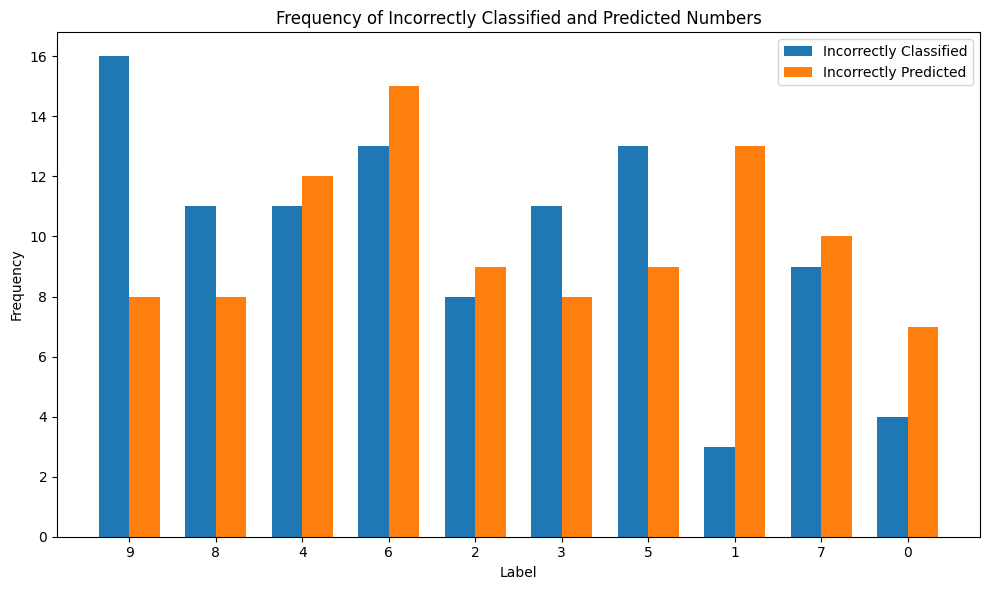

In [ ]:

# Convert predictions to class labels
predicted_output = model.predict([x_test_ravel,pos_feed_test])
predicted_labels = np.argmax(predicted_output, axis=1)

# Find indices of incorrectly classified samples
incorrect_indices = np.where(predicted_labels != y_test)[0]

# Count the frequency of both incorrectly classified and incorrectly predicted numbers
incorrect_numbers_count = {}
for idx in incorrect_indices:
    true_label = y_test[idx] # Extract scalar value from array
    predicted_label = predicted_labels[idx]

    # Count incorrectly classified numbers
    if true_label not in incorrect_numbers_count:
        incorrect_numbers_count[true_label] = {'classified': 1, 'predicted': 0}
    else:
        incorrect_numbers_count[true_label]['classified'] += 1

    # Count incorrectly predicted numbers
    if predicted_label not in incorrect_numbers_count:
        incorrect_numbers_count[predicted_label] = {'classified': 0, 'predicted': 1}
    else:
        incorrect_numbers_count[predicted_label]['predicted'] += 1

# Plot the graph
plt.figure(figsize=(10, 6))

labels = list(incorrect_numbers_count.keys())
classified_counts = [incorrect_numbers_count[label]['classified'] for label in labels]
predicted_counts = [incorrect_numbers_count[label]['predicted'] for label in labels]

bar_width = 0.35
index = np.arange(len(labels))

plt.bar(index, classified_counts, width=bar_width, label='Incorrectly Classified')
plt.bar(index + bar_width, predicted_counts, width=bar_width, label='Incorrectly Predicted')

plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Incorrectly Classified and Predicted Numbers')
plt.xticks(index + bar_width / 2, labels)
plt.legend()
plt.tight_layout()
plt.show()

313/313 [==============================] - 13s 42ms/step


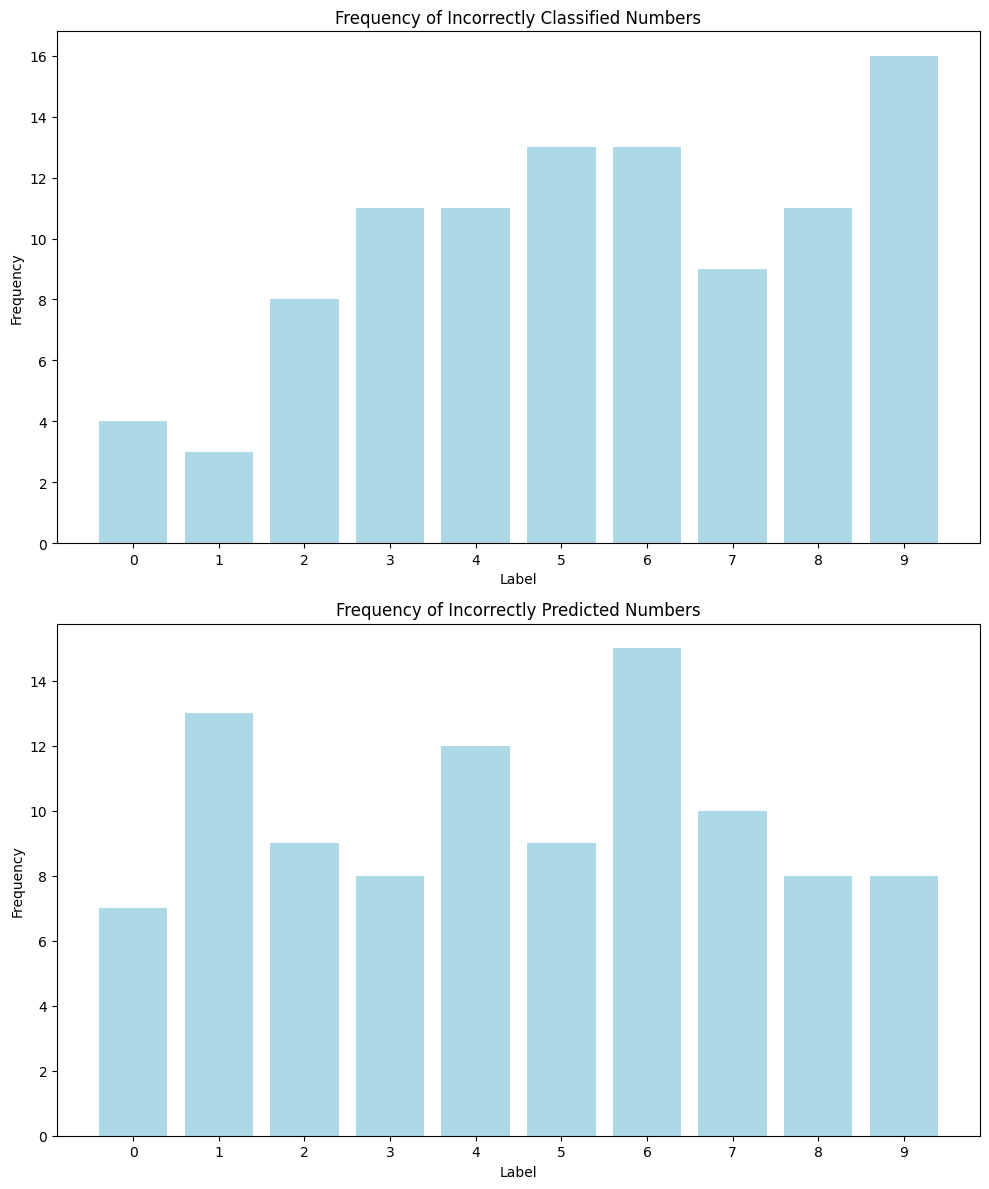

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions to class labels
predicted_output = model.predict([x_test_ravel,pos_feed_test])
predicted_labels = np.argmax(predicted_output, axis=1)

# Find indices of incorrectly classified samples
incorrect_indices = np.where(predicted_labels != y_test)[0]

# Count the frequency of both incorrectly classified and incorrectly predicted numbers
incorrect_numbers_count = {}
for idx in incorrect_indices:
    true_label = y_test[idx] # Extract scalar value from array
    predicted_label = predicted_labels[idx]

    # Count incorrectly classified numbers
    if true_label not in incorrect_numbers_count:
        incorrect_numbers_count[true_label] = {'classified': 1, 'predicted': 0}
    else:
        incorrect_numbers_count[true_label]['classified'] += 1

    # Count incorrectly predicted numbers
    if predicted_label not in incorrect_numbers_count:
        incorrect_numbers_count[predicted_label] = {'classified': 0, 'predicted': 1}
    else:
        incorrect_numbers_count[predicted_label]['predicted'] += 1

# Sort labels
labels = sorted(incorrect_numbers_count.keys())

# Extract counts
classified_counts = [incorrect_numbers_count[label]['classified'] for label in labels]
predicted_counts = [incorrect_numbers_count[label]['predicted'] for label in labels]

# Plot the graphs
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot for incorrectly classified numbers
axs[0].bar(labels, classified_counts, color='lightblue')
axs[0].set_title('Frequency of Incorrectly Classified Numbers')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Frequency')
axs[0].set_xticks(range(10))

# Plot for incorrectly predicted numbers
axs[1].bar(labels, predicted_counts, color='lightblue')
axs[1].set_title('Frequency of Incorrectly Predicted Numbers')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks(range(10))

plt.tight_layout()
plt.show()


In [ ]:
incorrect_numbers_count

{9: {'classified': 16, 'predicted': 8},
 8: {'classified': 11, 'predicted': 8},
 4: {'classified': 11, 'predicted': 12},
 6: {'classified': 13, 'predicted': 15},
 2: {'classified': 8, 'predicted': 9},
 3: {'classified': 11, 'predicted': 8},
 5: {'classified': 13, 'predicted': 9},
 1: {'classified': 3, 'predicted': 13},
 7: {'classified': 9, 'predicted': 10},
 0: {'classified': 4, 'predicted': 7}}

In [ ]:
# Calculate total counts of incorrectly predicted and classified samples
total_incorrectly_predicted = sum(counts['predicted'] for counts in incorrect_numbers_count.values())
total_incorrectly_classified = sum(counts['classified'] for counts in incorrect_numbers_count.values())

# Display the results
print("Total incorrectly predicted samples:", total_incorrectly_predicted)
print("Total incorrectly classified samples:", total_incorrectly_classified)

Total incorrectly predicted samples: 99
Total incorrectly classified samples: 99


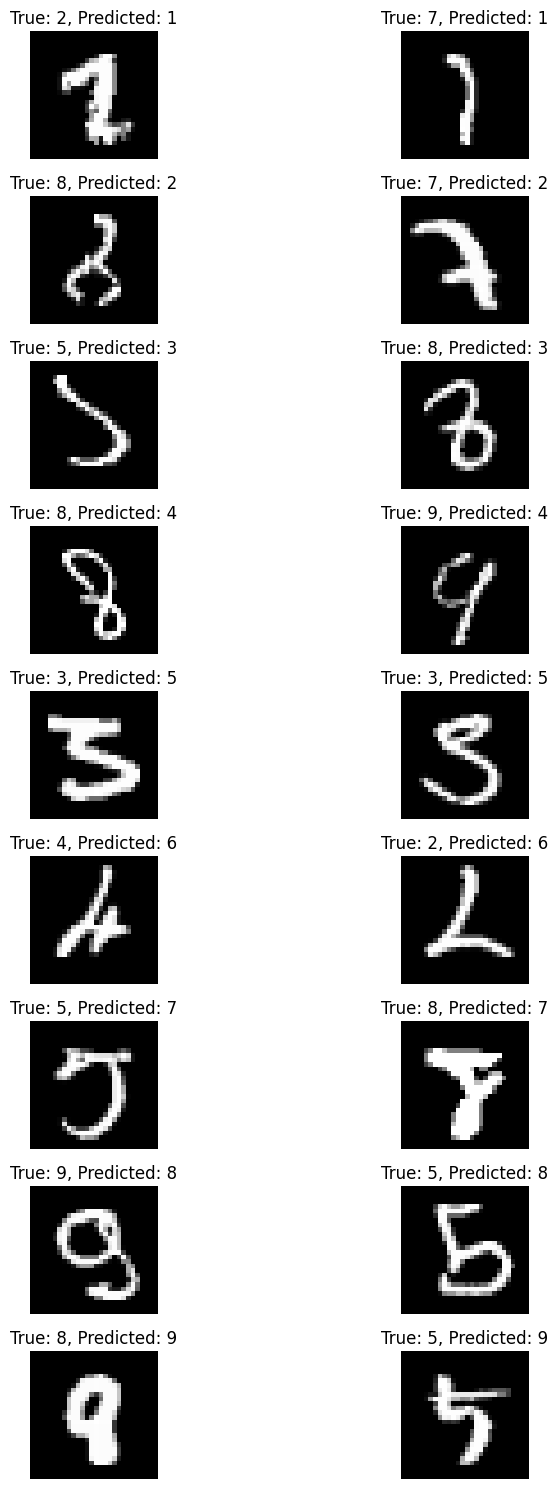

In [ ]:
# Plot some examples of incorrectly predicted images
plt.figure(figsize=(10, 15))

for label in range(1, 10):  # Iterate over labels 1 to 9
    # Find indices of incorrectly predicted samples for the current label
    incorrect_indices = np.where((y_test != label) & (predicted_labels == label))[0][:2]

    # Plot the selected examples
    for i, idx in enumerate(incorrect_indices):
        plt.subplot(9, 2, (label - 1) * 2 + i + 1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_test[idx]}, Predicted: {predicted_labels[idx]}')
        plt.axis('off')

plt.tight_layout()
plt.show()
